In [1]:
import torch
from torchvision.datasets import Flowers102
from torchvision.transforms import ToTensor
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
dataset = Flowers102(
    root='',
    split='train',
    download=True,
    transform=None
)

In [3]:
dataset[200]

(<PIL.Image.Image image mode=RGB size=670x500>, 19)

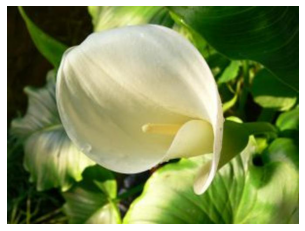

In [4]:
plt.imshow(dataset[200][0])
plt.axis('off')
plt.show()

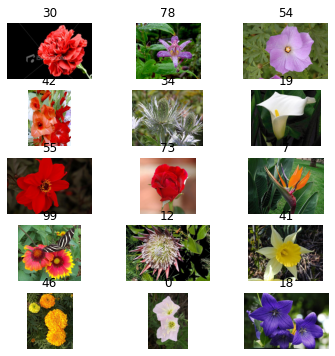

In [5]:
figure = plt.figure(figsize=(6, 6))
cols, rows = 3, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [6]:
# Can see images are different sizes so need to resize before training, also if classes are varied do various data augmentation techniques to make more training data 

In [7]:
labels = scipy.io.loadmat('flowers-102/imagelabels.mat')

In [11]:
labels

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009',
 '__version__': '1.0',
 '__globals__': [],
 'labels': array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)}